In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 데이터 불러오기

In [2]:
df = pd.read_csv('C:/Users/EL087/Desktop/MS_MachineLearning/data/advertising.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


# 다중회귀

## 변수 선택
* 3가지 독립변수 모두 선택

In [3]:
# -----------------------------------
# 독립변수, 종속변수 선택
# -----------------------------------
X = df[['TV','Radio','Newspaper']]
y = df['Sales']

<Axes: >

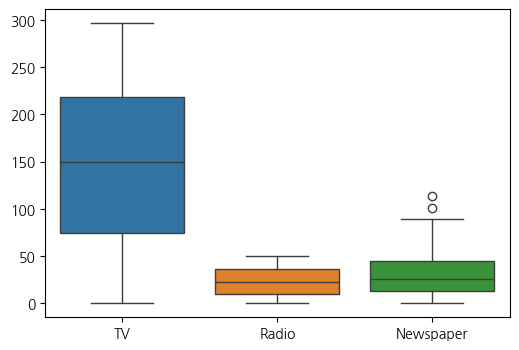

In [4]:
# -----------------------------------
# 독립변수의 데이터 분포 파악
# -----------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(X)

## 훈련세트 테스트세트 분할

In [5]:
# ------------------------------------------
# 훈련세트, 테스트세트 분할
# ------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(150, 3) (50, 3) (150,) (50,)


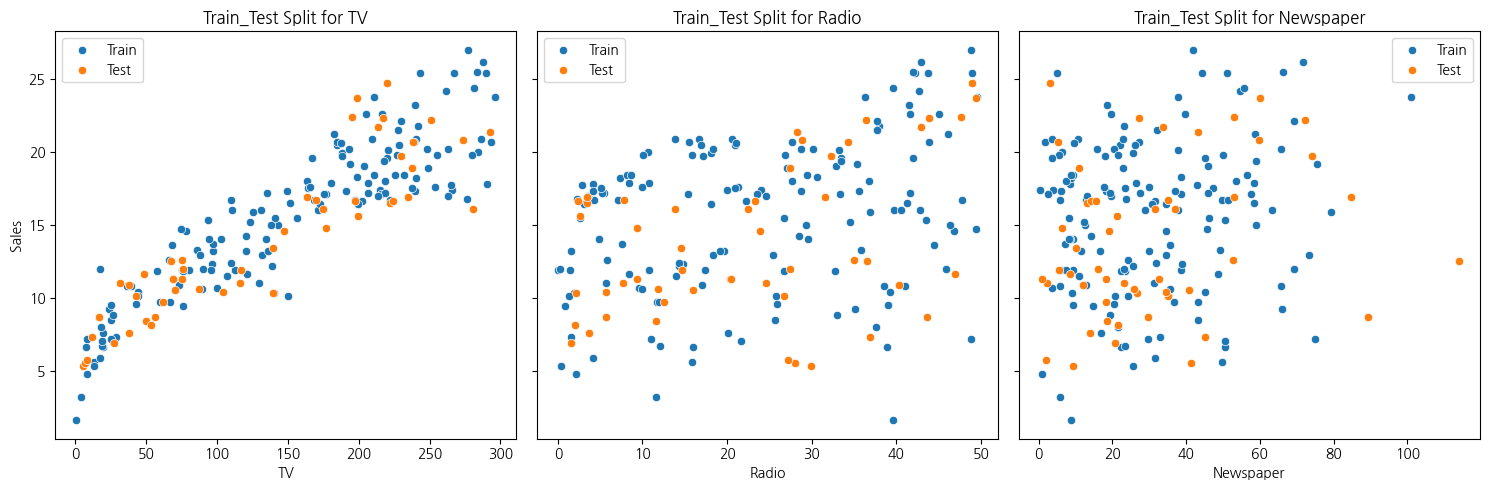

In [6]:
# ------------------------------------------
# 훈련세트, 테스트세트 분할 확인 시각화
# ------------------------------------------

# 독립변수 리스트
features = ['TV', 'Radio', 'Newspaper']

# 1행 3열의 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True) 

# 각 변수에 대해 산점도 그리기
for i, feature in enumerate(features):
    # 훈련 세트 산점도
    sns.scatterplot(x=X_train[feature], y=y_train, ax=axes[i], label="Train")
    
    # 테스트 세트 산점도
    sns.scatterplot(x=X_test[feature], y=y_test, ax=axes[i], label="Test")
    
    axes[i].set_title(f"Train_Test Split for {feature}")
    axes[i].set_xlabel(feature)
    axes[i].legend(loc='best')

plt.tight_layout() # 그래프 간격 자동 조정
plt.show()

## 스케일링
- 스케일링은 **데이터의 변수(특성)들이 가지는 값의 범위(Scale)를 통일하거나 분포를 조정**하는 데이터 전처리(Pre-processing) 과정
- 선형회귀 모델은 변수의 스케일에 영향을 받음 / 트리 모델은 스케일링의 영향을 거의 받지 않음

- 주요 목적:

1. **계수($\beta$) 해석의 용이성**
- 스케일링을 하지 않으면, 값의 범위가 큰 변수는 작은 변수에 비해 상대적으로 큰 회귀 계수$(\beta$)를 가지게 됨  
- 스케일링을 통해 모든 변수의 범위가 비슷해지면, 회귀 계수($\beta$)의 절댓값을 통해 해당 변수가 종속 변수에 미치는 상대적인 영향력을 더 쉽게 비교 가능

2. **최적화 알고리즘 (경사 하강법)의 안정성**
- 선형 회귀 모델은 보통 **경사 하강법(Gradient Descent)**이라는 최적화 알고리즘을 사용하여 최적의 회귀 계수를 찾음

- 변수들의 스케일 차이가 크면 손실 함수(Cost Function)의 모양이 매우 찌그러진 타원형이 되어,  
최적의 지점(Loss가 가장 낮은 곳)을 찾는 데 비효율적이거나 수렴하는 데 많은 시간이 걸림  
- 스케일링을 통해 손실 함수를 보다 대칭적인 원형에 가깝게 만들어주면, 경사 하강법이 더 빠르고 안정적으로 수렴

🛠️ 대표적인 스케일링 기법
1. **정규화 (Normalization, Min-Max Scaling)**  
- 목적: 데이터 값을 특정 범위 (보통 0과 1 사이)로 변환 
- 수식: $X_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$

2. **표준화 (Standardization)**
- 목적: 데이터의 평균을 0으로, 표준편차를 1로 변환하여 정규 분포와 유사하게 만듦  
- 수식: $X_{\text{std}} = \frac{X - \mu}{\sigma}$ (단, $\mu$: 평균, $\sigma$: 표준편차)

선형 회귀 모델에서는 데이터의 분포를 정규 분포 형태로 조정하는 **표준화(Standardization)**가 일반적으로 더 선호

In [7]:
# ------------------------------------------
# 독립변수 스케일링
# ------------------------------------------
from sklearn.preprocessing import StandardScaler    # 표준화 사용
scaler = StandardScaler()

train_scaled = scaler.fit_transform(X_train)  # 훈련데이터는 fit_transform()
test_scaled = scaler.transform(X_test)        # 테스트데이터는 transform()

1. 💡 fit( )의 역할: 변환 기준 학습 (훈련 데이터만)

    fit( ) 메서드는 데이터를 변환하는 데 필요한 **기준(파라미터)**을 학습
- MinMaxScaler (정규화)의 경우: 훈련 데이터($X\_\text{train}$)의 **최소값($\text{min}$)과 최대값($\text{max}$)**을 계산
- StandardScaler (표준화)의 경우: 훈련 데이터($X\_\text{train}$)의 **평균($\mu$)과 표준편차($\sigma$)**를 계산

2. 🛡️ 테스트 데이터에 fit( )을 사용하지 않는 이유 (데이터 누수 방지)

    만약 테스트 데이터에 fit( )을 사용한다면, 테스트 데이터의 최대/최소값 또는 평균/표준편차 정보가 스케일링 기준을 결정하는 데 사용

- 문제: 테스트 데이터는 미래의, 보지 못한 데이터를 모방  
 미래 데이터를 예측하는 모델을 만들 때, 미래 데이터의 통계 정보(평균, 최대값 등)를 미리 알고 사용한다면 이는 **부정 행위(데이터 누수)**와 같음

- 결과: 테스트 세트의 성능이 과대평가되어 실제 환경에 배포했을 때 성능이 기대에 미치지 못하게 됨

In [8]:
# ------------------------------------------
# 독립변수 데이터프레임 형태로 변환
# ------------------------------------------
X_train_scaled = pd.DataFrame(train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(test_scaled, columns=X_test.columns)

In [9]:
# ------------------------------------------
# 스케일링 결과 확인
# ------------------------------------------
pd.set_option('display.float_format', '{:.5f}'.format)  # 소수점 형식으로 출력

print(X_train_scaled.describe())

print()
print(f'각 변수의 평균: {X_train_scaled.iloc[:,0].mean():.5f}, {X_train_scaled.iloc[:,1].mean():.5f}, {X_train_scaled.iloc[:,2].mean():.5f}')
print(f'각 변수의 표준편차: {X_train_scaled.iloc[:,0].std():.5f}, {X_train_scaled.iloc[:,1].std():.5f}, {X_train_scaled.iloc[:,2].std():.5f}')

pd.reset_option('display.float_format')     # 원래 지수 형식으로 변환

             TV     Radio  Newspaper
count 150.00000 150.00000  150.00000
mean   -0.00000  -0.00000    0.00000
std     1.00335   1.00335    1.00335
min    -1.79519  -1.58162   -1.45958
25%    -0.78534  -0.89337   -0.86187
50%     0.13019  -0.10079   -0.22060
75%     0.79429   0.93748    0.73042
max     1.69124   1.75698    3.40923

각 변수의 평균: -0.00000, -0.00000, 0.00000
각 변수의 표준편차: 1.00335, 1.00335, 1.00335


<Axes: >

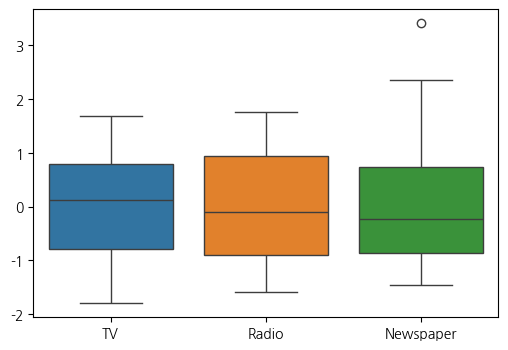

In [10]:
# ------------------------------------------
# 스케일링 결과 확인
# ------------------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(X_train_scaled)

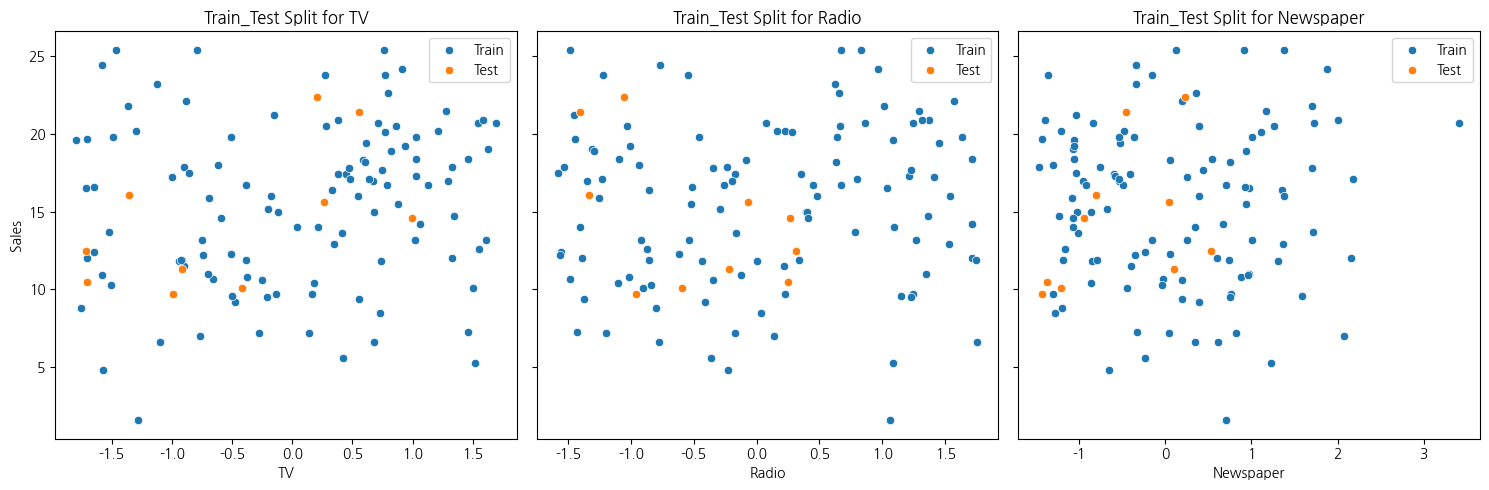

In [11]:
# ------------------------------------------
# 스케일링 된 훈련세트, 테스트세트 분할 확인 시각화
# ------------------------------------------

# 독립변수 리스트
features = ['TV', 'Radio', 'Newspaper']

# 1행 3열의 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True) 

# 각 변수에 대해 산점도 그리기
for i, feature in enumerate(features):
    # 훈련 세트 산점도
    sns.scatterplot(x=X_train_scaled[feature], y=y_train, ax=axes[i], label="Train")
    
    # 테스트 세트 산점도
    sns.scatterplot(x=X_test_scaled[feature], y=y_test, ax=axes[i], label="Test")
    
    axes[i].set_title(f"Train_Test Split for {feature}")
    axes[i].set_xlabel(feature)
    axes[i].legend(loc='best')

plt.tight_layout() # 그래프 간격 자동 조정
plt.show()

- **X축 범위**: 모든 변수가 -3에서 3 사이의 좁은 범위로 압축

    이는 StandardScaler를 사용하여 평균 0, 표준편차 1로 표준화했기 때문에 나타나는 정상적인 결과

- **Y축 (Sales)**: 여전히 0~25 범위를 유지 (종속변수는 스케일링하지 않았으므로)

- **시각적 특징**:

    X축이 매우 좁아지고 Y축은 그대로 유지되면서, 점들의 분포가 수직으로 늘어나고 가로로 압축된 것처럼 보임

    하지만 점들의 **상대적인 위치와 패턴(경향)**은 스케일링 전과 동일하게 유지

## 모델 생성 및 훈련

In [12]:
# ------------------------------------------
# LinearRegression 클래스 import
# ------------------------------------------
from sklearn.linear_model import LinearRegression

# ------------------------------------------
# 모델객체 생성하기
# ------------------------------------------
model = LinearRegression()

# ------------------------------------------
# 훈련데이터로 모델 훈련하기
# ------------------------------------------
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## 평가

In [13]:
from sklearn.metrics import mean_squared_error, \
                            mean_absolute_error, \
                            root_mean_squared_error, \
                            r2_score

# -----------------------------------
# 테스트데이터의 예측값
# -----------------------------------
y_pred = model.predict(X_test_scaled)

# -----------------------------------
# 모델 평가
# -----------------------------------
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('===다중회귀 모델의 평가결과===')
print(f'R2:{r2:.4f}')
print(f'RMSE:{rmse:.4f}')
print(f'MAE:{mae:.4f}')
print(f'MSE:{mse:.4f}')

===다중회귀 모델의 평가결과===
R2:0.9116
RMSE:1.5505
MAE:1.1200
MSE:2.4041


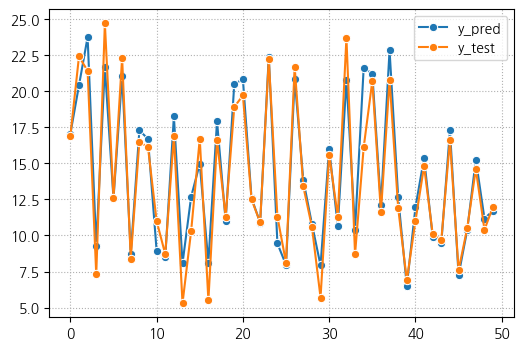

In [14]:
# ------------------------------------
# 실제값과 예측값 시각화 비교
# ------------------------------------
plt.figure(figsize=(6,4))
sns.lineplot(y_pred, marker='o', label='y_pred')
sns.lineplot(np.array(y_test), marker='o', label='y_test')
plt.grid(ls=':')
plt.legend()
pass

## 모델의 학습 결과

In [15]:
# ------------------------------------
# 회귀계수와 절편
# ------------------------------------
print(f'회귀계수:{model.coef_}')
print(f'절편:{model.intercept_}')

w1 = model.coef_[0]
w2 = model.coef_[1]
w3 = model.coef_[2]

b = model.intercept_

# ------------------------------------
# 모델이 도출한 규칙
# ------------------------------------
print('=== 모델이 학습한 규칙 ===')
print(f'{w1} * tv + {w2} * radio + {w3} * newspaper + {b}')

회귀계수:[4.63204383 1.48207916 0.0889496 ]
절편:15.570666666666671
=== 모델이 학습한 규칙 ===
4.632043828977965 * tv + 1.482079157483419 * radio + 0.08894959848537343 * newspaper + 15.570666666666671


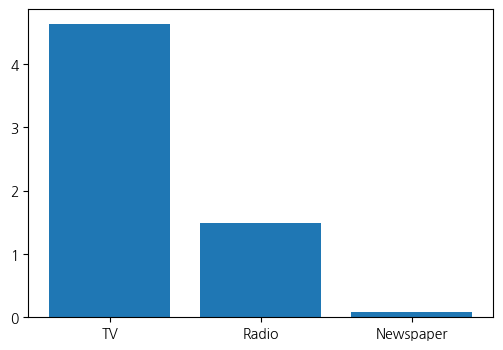

In [16]:
# ------------------------------------
# 회귀계수 시각화
# ------------------------------------
plt.figure(figsize=(6,4))
plt.bar(["TV", "Radio", "Newspaper"], model.coef_);

- **회귀계수(model.coef_)**는 다중 선형 회귀 모델에서 각 독립변수가 종속변수에 미치는 영향의 크기와 방향을 나타내는 핵심 값

    위에서 스케일링을 하였으므로 표준화된 회귀계수는 모두 동일한 스케일(평균 0, 표준편차 1)을 기반으로 하기 때문에,  
    계수의 절댓값 크기만으로 어떤 독립변수가 종속변수에 상대적으로 가장 큰 영향을 미치는지 직관적으로 비교할 수 있음

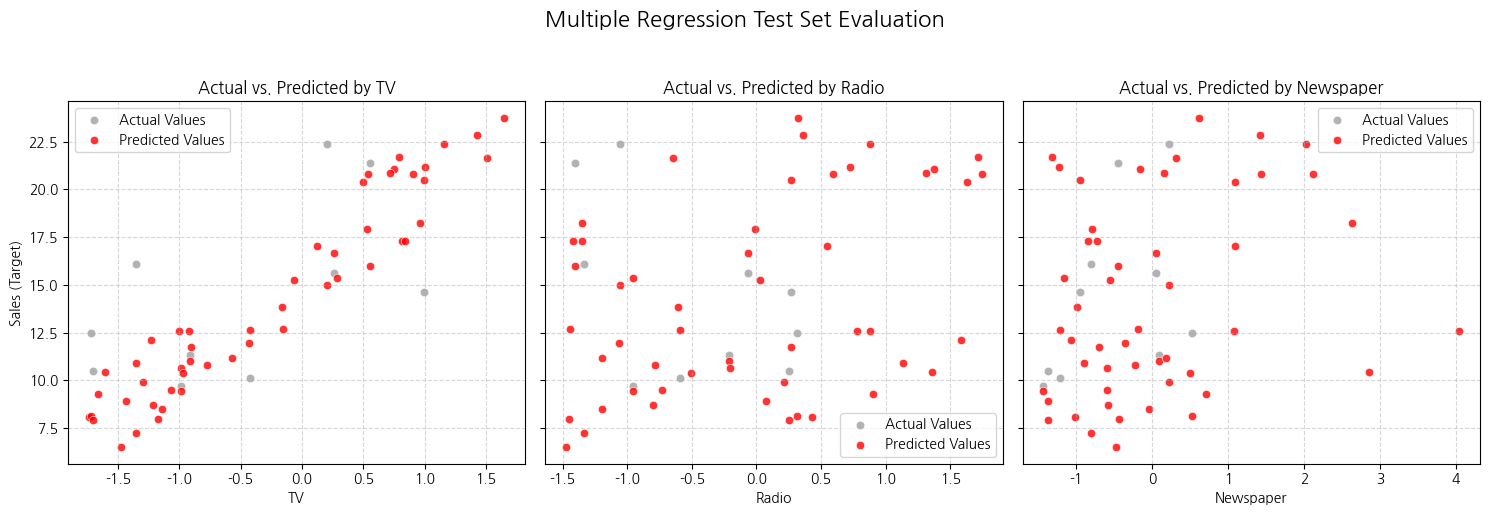

In [17]:
# ------------------------------------------
# 테스트데이터 실제값과 예측값 확인
# ------------------------------------------

# 1. 시각화를 위한 통합 데이터프레임 생성
# X_test, y_test, y_pred를 하나의 DataFrame으로 합칩니다.
df_test_pred = X_test_scaled.copy()
df_test_pred['Actual'] = y_test
df_test_pred['Predicted'] = y_pred

# 2. 1행 3열 서브플롯 생성
features = ['TV', 'Radio', 'Newspaper']
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True) # figsize=(15, 5)로 설정하여 가독성 확보

# 3. 각 독립변수에 대해 산점도 그리기
for i, feature in enumerate(features):
    # 실제 값 산점도 (파란색 또는 회색)
    sns.scatterplot(x=df_test_pred[feature], 
                    y=df_test_pred['Actual'], 
                    ax=axes[i], 
                    color='gray', 
                    alpha=0.6,
                    label='Actual Values')
    
    # 예측 값 산점도 (주황색 또는 빨간색)
    sns.scatterplot(x=df_test_pred[feature], 
                    y=df_test_pred['Predicted'], 
                    ax=axes[i], 
                    color='red', 
                    alpha=0.8,
                    label='Predicted Values')
    
    axes[i].set_title(f"Actual vs. Predicted by {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Sales (Target)")
    axes[i].legend(loc='best')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Multiple Regression Test Set Evaluation", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # 전체 제목을 위한 간격 조정
plt.show()

- 그래프 해석
1. 📺 TV 그래프: 강한 선형 관계
- 해석: 회색 점(Actual Values)과 빨간색 점(Predicted Values)이 모두 강력한 우상향 패턴을 따르고 있음  
    이는 TV 지출이 증가할수록 판매량(Sales)이 일관되게 증가한다는 것을 의미합니다.

- 결과: 모델은 이 강력한 선형 관계를 잘 학습했으며, 예측값(빨간 점)도 실제 값(회색 점)의 패턴을 잘 따라가고 있어 모델 성능이 가장 좋게 보이는 부분  
(스케일링은 X축의 단위만 바꿨을 뿐, 패턴은 그대로 유지)

2. 📻 Radio 및 📰 Newspaper 그래프: 약한 관계 또는 높은 잔차(오차)
- 해석: 이 두 그래프에서는 $X$축 값이 증가해도 $Y$축 값(Sales)이 일관되게 증가하거나 감소하는 뚜렷한 선형 패턴이 보이지 않음  
데이터 포인트(회색 점) 자체가 이미 넓게 흩어져 있어 Sales와 Radio 및 Newspaper 간의 개별적인 선형 관계가 약함을 나타냄

## 새로운 값 예측하기
* 스케일링 된 데이터로 훈련했으므로 예측할 데이터도 스케일링을 해주어야 한다.
* 훈련세트에서 사용한 스케일러를 이용하여 스케일링한다.
* 이 때는 fit 하지 않고 transform만 한다.

In [18]:
# ---------------------------
# 새로운 값 입력받기
# ---------------------------
new_tv = int(input('tv 광고비 >>>'))
new_radio = int(input('radio 광고비 >>>'))
new_newspaper = int(input('newspaper 광고비 >>>'))

In [19]:
# ---------------------------
# 새로운 값 스케일링
# ---------------------------
new_data = [[new_tv,new_radio,new_newspaper]]
new_data = pd.DataFrame(new_data, columns=X_test.columns)

new_data_scaled = scaler.transform(new_data)
new_data_scaled = pd.DataFrame(new_data_scaled, columns=X_test.columns)

In [20]:
# ---------------------------
# 새로운 값으로 예측
# ---------------------------
model.predict(new_data_scaled)

array([15.80426509])